In [78]:
import torch
import torch.nn as nn 
import torchvision.datasets as datasets
from torchvision.transforms import transforms 
import matplotlib.pyplot as plt 
from torchvision.datasets import MNIST 
import time 
import torch.optim as optim
from torch.utils.data import DataLoader 
import numpy as np 

##### 1. Write the code for downloading and formatting the data.

In [64]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset.transform = transform
test_dataset.transform = transform

In [68]:
def make_train_test_data(train_dataset, test_dataset, n = None):
    torch.manual_seed(1) 
    if n is not None:
        print(n)
        train_data = torch.cat([train_dataset[i][0] for i in range(len(train_dataset))], dim=0)
        indices = torch.randperm(len(train_data))[:n]
        train_data = torch.stack([train_data[i] for i in indices])
        train_targets = torch.zeros(train_dataset.targets.shape[0], 10)
        train_targets[torch.arange(train_dataset.targets.shape[0]), train_dataset.targets] = 1
        train_targets = torch.stack([train_targets[i] for i in indices])
    else:
        train_data = torch.cat([train_dataset[i][0] for i in range(len(train_dataset))], dim=0)
        train_targets = torch.zeros(train_dataset.targets.shape[0], 10)
        train_targets[torch.arange(train_dataset.targets.shape[0]), train_dataset.targets] = 1
        
    
    test_data = torch.cat([test_dataset[i][0] for i in range(len(test_dataset))], dim=0)
    test_targets = torch.zeros(test_dataset.targets.shape[0], 10)
    test_targets[torch.arange(test_dataset.targets.shape[0]), test_dataset.targets] = 1
        
    return train_data, test_data, train_targets, test_targets 
    

In [86]:
X_tr, X_ts, y_tr, y_ts = make_train_test_data(train_dataset, test_dataset)

In [87]:
X_tr.shape, X_ts.shape, y_tr.shape, y_ts.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000, 10]),
 torch.Size([10000, 10]))

In [89]:
X_tr[0], y_tr[0]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000,

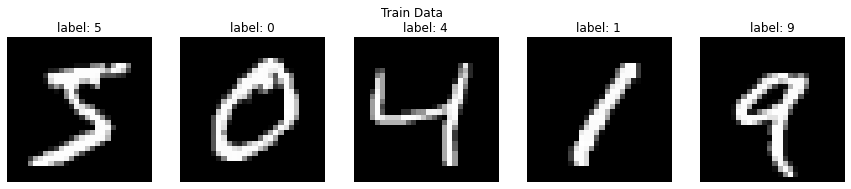

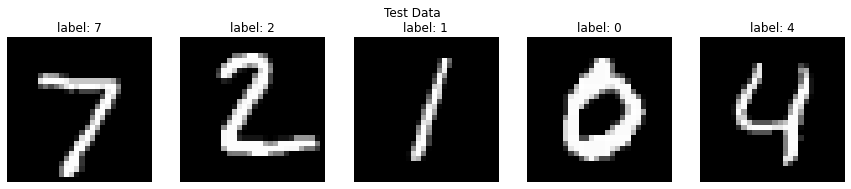

In [90]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_tr[i], cmap='gray')
    ax.set_title("label: " +str(y_tr[i].argmax().item()))
    ax.axis('off')
plt.suptitle("Train Data")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_ts[i], cmap='gray')
    ax.set_title("label: " +str(y_ts[i].argmax().item()))
    ax.axis('off')
plt.suptitle("Test Data")
plt.show()

##### 2. Write the code for minibatch SGD implementation for your linear MNIST classifier.

In [91]:

def train_model(train_data, test_data, train_targets, test_targets, ITR=500, B = 100, eta=0.01):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = [] 
    W = torch.randn(train_data.shape[1]*train_data.shape[2] , train_targets.shape[1])               # define the weight matrix 
    training_time = 0 
    for i in range(ITR):                                                                            # Iteration starts (`ITR` times loop)
        indices = torch.randperm(len(train_data))                                                   # rearrange the indices of the train samples
        start = time.time()                                                                         # start time counter for the iteration
        for j in range(0, len(train_data), B):                                                      #   Batch starts (`train_size/B` times loop)
            batch_indices = indices[j:j+B]                                                          #   get the train indices for this batch
            x_batch = train_data[batch_indices].view(-1, train_data.shape[1]*train_data.shape[2])   #   reshape the train images into 1D
            y_batch = train_targets[batch_indices]                                                  #   get train labels for this batch
            y_pred = x_batch @ W                                                                    #   predicting train labels 
            loss = ((y_pred - y_batch)**2).sum() / (2*B)                                            #   calculate loss for this batch of data
            
            train_acc = (y_pred.argmax(dim=1) == y_batch.argmax(dim=1)).float().mean()              #   calculate accuracy for this batch of data    
            grad = torch.matmul(torch.transpose(x_batch, 0, 1), (y_pred - y_batch)) / B             #   calculate the gradients for this batch
            
            W -= eta * grad                                                                         #   Update the weights based on this batch 
        training_time += (time.time() - start)                                                      # add time spent for training 
        train_losses.append(loss.item())                                                            # append train loss for this iteration         
        train_accs.append(train_acc.item())                                                         # append train accuracy for this iteration 
        
        # evaluate the model on test set for this iteration 
        with torch.no_grad():
            test_x = test_data.view(-1, train_data.shape[1]*train_data.shape[2])                    # test image flattening to 1D
            test_y = test_targets                                                                   # test labels 
            test_pred = test_x @ W                                                                  # predicting test labels
            test_loss = ((test_pred - test_y)**2).sum() / (2*len(test_data))                        # calculating test loss 
            test_acc = (test_pred.argmax(dim=1) == test_y.argmax(dim=1)).float().mean()             # calculating test accuracy 
            test_losses.append(test_loss.item())                                                    # append test loss for this iteration 
            test_accs.append(test_acc.item())                                                       # append test accuracy for this iteration
        print(f"Iteration {i}: Loss = {loss:.4f}, Accuracy = {train_acc:.4f} Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")

    print(f"Total training time: {training_time:0.2f}s")
    history = dict() 
    history['acc']       = train_accs 
    history['loss']      = train_losses
    history['test_acc']  = test_accs 
    history['test_loss'] = test_losses 
    return history 


In [92]:
def plot_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ax0 = axes[0] 
    ax0.plot(history['loss'], label='training')
    ax0.plot(history['test_loss'], label='test')
    ax0.set_xlabel('Iteration')
    ax0.set_ylabel('Loss')
    ax0.legend()

    ax1 = axes[1] 
    ax1.plot(history['acc'], label='training')
    ax1.plot(history['test_acc'], label='test')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    plt.show()

### 3. Run your code with batch sizes B = 1, 10, 100, 1000

**`B=1`**

Iteration 0: Loss = 0.7468, Accuracy = 1.0000 Test Loss = 0.8865, Test Accuracy = 0.5570
Iteration 1: Loss = 0.2408, Accuracy = 1.0000 Test Loss = 0.4903, Test Accuracy = 0.6954
Iteration 2: Loss = 0.1556, Accuracy = 1.0000 Test Loss = 0.4225, Test Accuracy = 0.7087
Iteration 3: Loss = 0.4108, Accuracy = 0.0000 Test Loss = 0.4517, Test Accuracy = 0.6485
Iteration 4: Loss = 0.2358, Accuracy = 1.0000 Test Loss = 0.4915, Test Accuracy = 0.6797
Iteration 5: Loss = 0.8525, Accuracy = 0.0000 Test Loss = 0.4895, Test Accuracy = 0.6556
Iteration 6: Loss = 0.3473, Accuracy = 1.0000 Test Loss = 0.3786, Test Accuracy = 0.7291
Iteration 7: Loss = 0.2354, Accuracy = 1.0000 Test Loss = 0.4483, Test Accuracy = 0.5725
Iteration 8: Loss = 0.6311, Accuracy = 1.0000 Test Loss = 0.3916, Test Accuracy = 0.6910
Iteration 9: Loss = 0.1125, Accuracy = 1.0000 Test Loss = 0.3631, Test Accuracy = 0.6890
Iteration 10: Loss = 0.2425, Accuracy = 1.0000 Test Loss = 0.3801, Test Accuracy = 0.7024
Iteration 11: Loss =

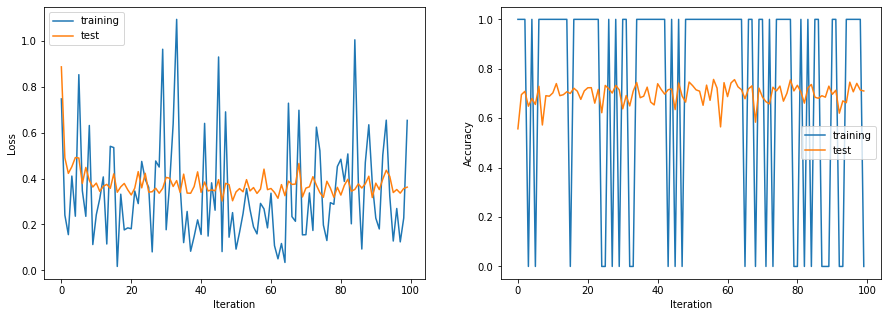

In [93]:
history1 = train_model(X_tr, X_ts, y_tr, y_ts, ITR=100, B = 1)
plot_history(history1) 

I have used only 100 epochs. Becasue, I tried with 4000 epochs previously and the line does not improve over the iterations. It converges early. 
That is why when I am running the models again for the final time, I am using less number of iterations. 

`Total training time`: 762.59s for 100 epoch. `7.63`s per epoch. 

**`B=10`**

Iteration 0: Loss = 5.4326, Accuracy = 0.3000 Test Loss = 4.8959, Test Accuracy = 0.2515
Iteration 1: Loss = 1.7612, Accuracy = 0.4000 Test Loss = 2.3194, Test Accuracy = 0.3311
Iteration 2: Loss = 1.6555, Accuracy = 0.6000 Test Loss = 1.5298, Test Accuracy = 0.4245
Iteration 3: Loss = 0.8892, Accuracy = 0.7000 Test Loss = 1.0444, Test Accuracy = 0.5138
Iteration 4: Loss = 0.4246, Accuracy = 0.9000 Test Loss = 0.8248, Test Accuracy = 0.5678
Iteration 5: Loss = 0.6628, Accuracy = 0.5000 Test Loss = 0.6954, Test Accuracy = 0.6248
Iteration 6: Loss = 0.8505, Accuracy = 0.5000 Test Loss = 0.6026, Test Accuracy = 0.6647
Iteration 7: Loss = 0.3344, Accuracy = 0.8000 Test Loss = 0.5282, Test Accuracy = 0.7046
Iteration 8: Loss = 0.7803, Accuracy = 0.7000 Test Loss = 0.4746, Test Accuracy = 0.7199
Iteration 9: Loss = 0.5167, Accuracy = 0.7000 Test Loss = 0.4423, Test Accuracy = 0.7425
Iteration 10: Loss = 0.3904, Accuracy = 0.7000 Test Loss = 0.4185, Test Accuracy = 0.7428
Iteration 11: Loss =

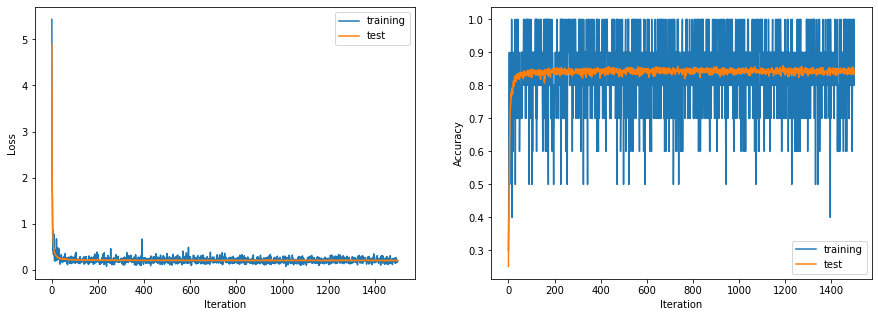

In [94]:
history2 = train_model(X_tr, X_ts, y_tr, y_ts, ITR=1500, B = 10)
plot_history(history2)

I have used only 1500 epochs. Becasue, I tried with 4000 epochs previously and the line does not improve over the iterations. It converges early. 
That is why when I am running the models again for the final time, I am using less number of iterations. 

`Total training time`: 1160.95s for 1500 epochs. `0.77`s per epoch. 

**`B=100`**

Iteration 0: Loss = 27.6212, Accuracy = 0.1400 Test Loss = 25.5890, Test Accuracy = 0.1379
Iteration 1: Loss = 15.9729, Accuracy = 0.1300 Test Loss = 16.6215, Test Accuracy = 0.1549
Iteration 2: Loss = 13.9294, Accuracy = 0.2200 Test Loss = 12.5842, Test Accuracy = 0.1673
Iteration 3: Loss = 8.9295, Accuracy = 0.1600 Test Loss = 10.1827, Test Accuracy = 0.1824
Iteration 4: Loss = 8.5734, Accuracy = 0.1600 Test Loss = 8.5728, Test Accuracy = 0.1934
Iteration 5: Loss = 7.2811, Accuracy = 0.2300 Test Loss = 7.3613, Test Accuracy = 0.2048
Iteration 6: Loss = 7.0605, Accuracy = 0.3100 Test Loss = 6.4593, Test Accuracy = 0.2104
Iteration 7: Loss = 5.2826, Accuracy = 0.2300 Test Loss = 5.7221, Test Accuracy = 0.2173
Iteration 8: Loss = 5.1966, Accuracy = 0.2600 Test Loss = 5.1371, Test Accuracy = 0.2225
Iteration 9: Loss = 4.4050, Accuracy = 0.2700 Test Loss = 4.6323, Test Accuracy = 0.2391
Iteration 10: Loss = 4.5124, Accuracy = 0.3000 Test Loss = 4.2148, Test Accuracy = 0.2495
Iteration 11:

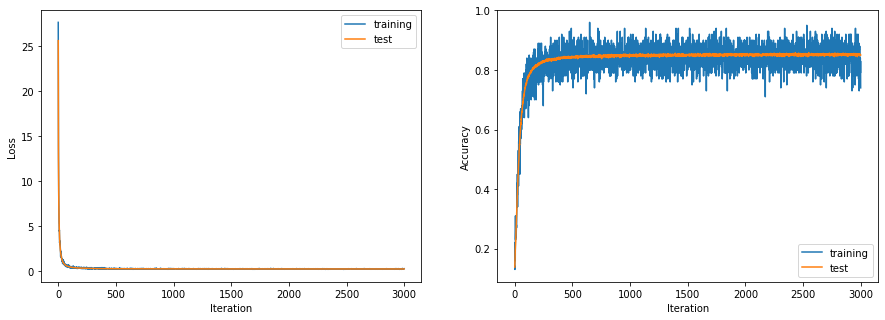

In [96]:
history3 = train_model(X_tr, X_ts, y_tr, y_ts, ITR=3000, B = 100)
plot_history(history3)

I have used 3000 epochs. Becasue, I tried with 4000 epochs previously and the line does not improve over the iterations. It converges early. 
That is why when I am running the models again for the final time, I am using less number of iterations. 

`Total training time`: 380.83s for 3000 epochs. `0.13`s per epoch. 

**`B=1000`**

Iteration 0: Loss = 98.6488, Accuracy = 0.0950 Test Loss = 94.5800, Test Accuracy = 0.1004
Iteration 1: Loss = 66.1937, Accuracy = 0.1250 Test Loss = 65.8526, Test Accuracy = 0.1151
Iteration 2: Loss = 53.9449, Accuracy = 0.1270 Test Loss = 52.5421, Test Accuracy = 0.1255
Iteration 3: Loss = 44.5077, Accuracy = 0.1590 Test Loss = 44.4828, Test Accuracy = 0.1314
Iteration 4: Loss = 39.9347, Accuracy = 0.1420 Test Loss = 39.0079, Test Accuracy = 0.1360
Iteration 5: Loss = 34.8321, Accuracy = 0.1300 Test Loss = 34.9644, Test Accuracy = 0.1410
Iteration 6: Loss = 32.7338, Accuracy = 0.1540 Test Loss = 31.8262, Test Accuracy = 0.1455
Iteration 7: Loss = 29.9426, Accuracy = 0.1540 Test Loss = 29.3044, Test Accuracy = 0.1470
Iteration 8: Loss = 28.0403, Accuracy = 0.1460 Test Loss = 27.2040, Test Accuracy = 0.1488
Iteration 9: Loss = 25.3490, Accuracy = 0.1550 Test Loss = 25.4495, Test Accuracy = 0.1534
Iteration 10: Loss = 25.1376, Accuracy = 0.1590 Test Loss = 23.9367, Test Accuracy = 0.153

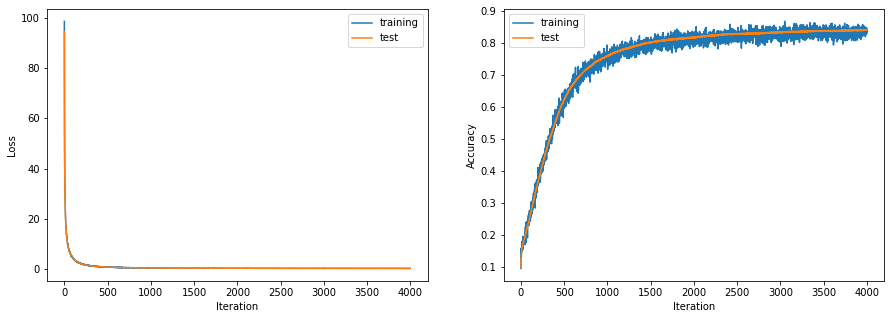

In [95]:
history4 = train_model(X_tr, X_ts, y_tr, y_ts, ITR=4000, B = 1000)
plot_history(history4)

`Total training time`: 260.99s for 4000 epochs. `0.065`s per epoch. 

### 4. Comment on the role of batch size.

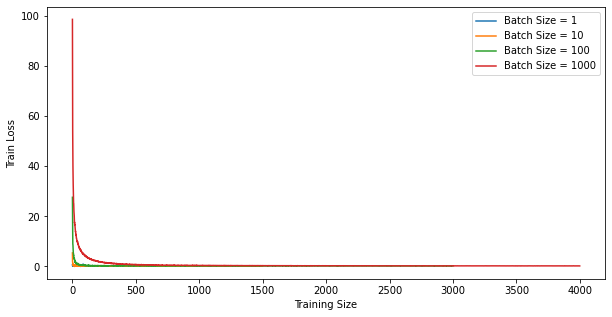

In [100]:
plt.figure(figsize=(10,5))
plt.plot(history1['loss'], label='Batch Size = 1')
plt.plot(history2['loss'], label='Batch Size = 10')
plt.plot(history3['loss'], label='Batch Size = 100')
plt.plot(history4['loss'], label='Batch Size = 1000')
plt.legend()
plt.xlabel('Training Size')
plt.ylabel('Train Loss')
plt.show()

**`Training Loss`:**
 This plot shows the training loss over the iterations for different batch sizes. We can see that, when the batch size increases, it takes comparatively more time to converge to the minimum loss. 

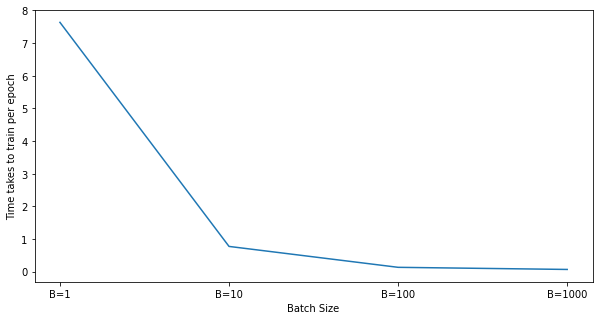

In [109]:
time = {'B=1':7.63, 'B=10':0.77, 'B=100':0.13, 'B=1000':0.065} 
plt.figure(figsize=(10,5)) 
plt.plot(time.keys(), time.values())
plt.xlabel('Batch Size')
plt.ylabel('Time takes to train per epoch')
plt.show()

**`Training Time`:** I have plotted the training time per epoch for each batch size. When batch time is low it take a lot of time to train. On the other hand, increasing batch size reduces training time in each iteration. 

In [115]:
train_loss = list()
train_acc  = list()
test_loss  = list()
test_acc0   = list() 

histories = [history1, history2, history3, history4]
for h in histories:
    best_score_idx = torch.argmax(torch.Tensor(h['test_acc'])).item()
    train_loss.append(h['loss'][best_score_idx])
    train_acc.append(h['acc'][best_score_idx])
    test_loss.append(h['test_loss'][best_score_idx])
    test_acc0.append(h['test_acc'][best_score_idx]) 

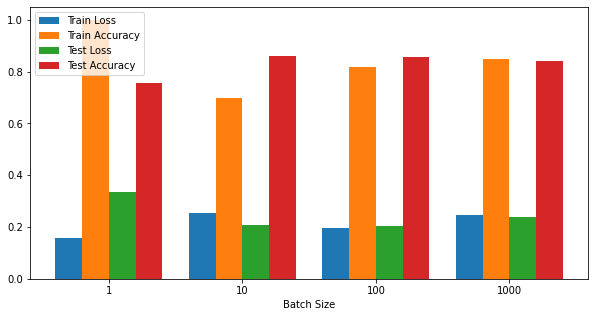

In [116]:
plt.figure(figsize=(10,5))
x_tick = ['1', '10', '100', '1000']
x_pos = np.arange(len(x_tick)) 
width = 0.2
plt.bar(x_pos - 1.5 * width, train_loss, width, label='Train Loss')
plt.bar(x_pos - 0.5 * width, train_acc, width, label='Train Accuracy')
plt.bar(x_pos + 0.5 * width, test_loss, width, label='Test Loss')
plt.bar(x_pos + 1.5 * width, test_acc0, width, label='Test Accuracy')

plt.xticks(x_pos, x_tick)
plt.legend()
plt.xlabel('Batch Size')
plt.show()

**`Observer Performance`:** I searched for the highest test performance and the other parameters in that iteration. I did this for all batch sizes. Then, plotted this bar chart to see the best test accuracy vs batch size. It looks like, choice of batch size is important. B=100 seems like work better than others in terms of all the 4 metrics - train/test accuracy and train/test loss. 

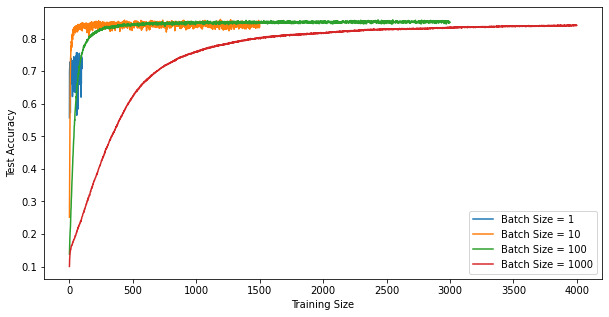

In [99]:
plt.figure(figsize=(10,5))
plt.plot(history1['test_acc'], label='Batch Size = 1')
plt.plot(history2['test_acc'], label='Batch Size = 10')
plt.plot(history3['test_acc'], label='Batch Size = 100')
plt.plot(history4['test_acc'], label='Batch Size = 1000')
plt.legend()
plt.xlabel('Training Size')
plt.ylabel('Test Accuracy')
plt.show()

**`Test Accuracy:`** This plot shows the test accuracy for each batch size. B=1 performs worst. It does not increase performance over the iterations. On the contrary, other batch size choices increas test accuracy over iterations. However, a larger batch size takes time to reach to the best test accuracy. We can see from this plot that, B=100 reaches to best test accuracy reasonably faster and the test accuracy is also higher. We can say the similar for B=10 just for the test accuracy. 

**`Overall Conclusion`:** Considering all the factors - Train loss, Time to train, Time to reach optimized point, Test accuracy, B=100 is the best choice for batch size in this problem. 

### 5. The role of training dataset size:

`Training Data = 100`

100
torch.Size([100, 28, 28]) torch.Size([10000, 28, 28])
Iteration 0: Loss = 582.9546, Accuracy = 0.0800 Test Loss = 362.4759, Test Accuracy = 0.1140
Iteration 1: Loss = 391.3271, Accuracy = 0.1200 Test Loss = 289.5626, Test Accuracy = 0.1107
Iteration 2: Loss = 311.2824, Accuracy = 0.1200 Test Loss = 257.8577, Test Accuracy = 0.1056
Iteration 3: Loss = 274.1873, Accuracy = 0.1200 Test Loss = 241.7553, Test Accuracy = 0.1060
Iteration 4: Loss = 253.8801, Accuracy = 0.1400 Test Loss = 231.6591, Test Accuracy = 0.1061
Iteration 5: Loss = 240.3681, Accuracy = 0.1500 Test Loss = 223.9949, Test Accuracy = 0.1051
Iteration 6: Loss = 229.8164, Accuracy = 0.1600 Test Loss = 217.4391, Test Accuracy = 0.1037
Iteration 7: Loss = 220.7364, Accuracy = 0.1600 Test Loss = 211.5018, Test Accuracy = 0.1028
Iteration 8: Loss = 212.5350, Accuracy = 0.1700 Test Loss = 205.9974, Test Accuracy = 0.1032
Iteration 9: Loss = 204.9622, Accuracy = 0.1700 Test Loss = 200.8497, Test Accuracy = 0.1042
Iteration 10

/var/folders/bg/yqgwsftd079fpjycqm6w_4_40000gp/T/ipykernel_2670/1392350790.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_dataset.data, dtype=torch.float32) / 255
/var/folders/bg/yqgwsftd079fpjycqm6w_4_40000gp/T/ipykernel_2670/1392350790.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_dataset.data, dtype=torch.float32) / 255


Iteration 26: Loss = 126.8049, Accuracy = 0.2000 Test Loss = 147.3589, Test Accuracy = 0.1061
Iteration 27: Loss = 124.0364, Accuracy = 0.2000 Test Loss = 145.4736, Test Accuracy = 0.1057
Iteration 28: Loss = 121.3926, Accuracy = 0.2000 Test Loss = 143.6736, Test Accuracy = 0.1059
Iteration 29: Loss = 118.8655, Accuracy = 0.2000 Test Loss = 141.9532, Test Accuracy = 0.1064
Iteration 30: Loss = 116.4476, Accuracy = 0.2000 Test Loss = 140.3074, Test Accuracy = 0.1069
Iteration 31: Loss = 114.1323, Accuracy = 0.2000 Test Loss = 138.7313, Test Accuracy = 0.1068
Iteration 32: Loss = 111.9132, Accuracy = 0.2100 Test Loss = 137.2206, Test Accuracy = 0.1074
Iteration 33: Loss = 109.7846, Accuracy = 0.2100 Test Loss = 135.7713, Test Accuracy = 0.1068
Iteration 34: Loss = 107.7408, Accuracy = 0.2100 Test Loss = 134.3795, Test Accuracy = 0.1067
Iteration 35: Loss = 105.7771, Accuracy = 0.2100 Test Loss = 133.0418, Test Accuracy = 0.1071
Iteration 36: Loss = 103.8886, Accuracy = 0.2100 Test Loss =

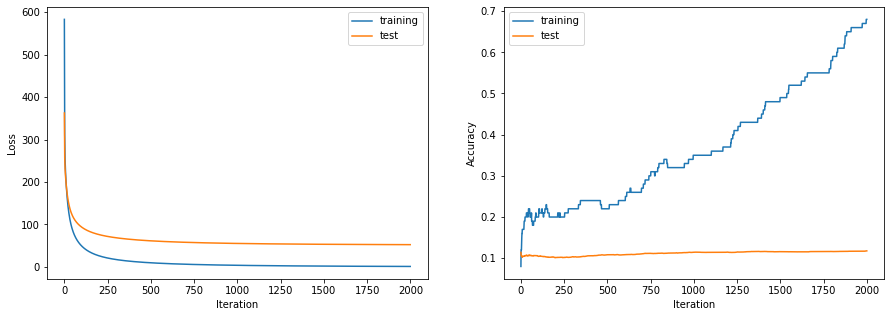

In [33]:
X_tr, X_ts, y_tr, y_ts = make_train_test_data(train_dataset, test_dataset, n=100)
print(X_tr.shape, X_ts.shape)
history5 = train_model(X_tr, X_ts, y_tr, y_ts, ITR=2000)
plot_history(history5) 

`Training Data = 500`

500
torch.Size([500, 28, 28]) torch.Size([10000, 28, 28])
Iteration 0: Loss = 263.6085, Accuracy = 0.1300 Test Loss = 235.0645, Test Accuracy = 0.1068
Iteration 1: Loss = 220.5105, Accuracy = 0.1400 Test Loss = 203.3869, Test Accuracy = 0.1059
Iteration 2: Loss = 166.4272, Accuracy = 0.1000 Test Loss = 181.7765, Test Accuracy = 0.1099
Iteration 3: Loss = 161.8938, Accuracy = 0.1300 Test Loss = 164.4771, Test Accuracy = 0.1115
Iteration 4: Loss = 159.3849, Accuracy = 0.0800 Test Loss = 151.0813, Test Accuracy = 0.1145
Iteration 5: Loss = 148.3352, Accuracy = 0.1600 Test Loss = 140.1876, Test Accuracy = 0.1181
Iteration 6: Loss = 121.7409, Accuracy = 0.1300 Test Loss = 131.1083, Test Accuracy = 0.1191
Iteration 7: Loss = 123.4297, Accuracy = 0.1900 Test Loss = 123.6000, Test Accuracy = 0.1194
Iteration 8: Loss = 113.6706, Accuracy = 0.1300 Test Loss = 116.8933, Test Accuracy = 0.1207
Iteration 9: Loss = 108.7630, Accuracy = 0.1600 Test Loss = 111.2071, Test Accuracy = 0.1218
Iteration 10

/var/folders/bg/yqgwsftd079fpjycqm6w_4_40000gp/T/ipykernel_2670/1392350790.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_dataset.data, dtype=torch.float32) / 255
/var/folders/bg/yqgwsftd079fpjycqm6w_4_40000gp/T/ipykernel_2670/1392350790.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_dataset.data, dtype=torch.float32) / 255


Iteration 18: Loss = 70.0997, Accuracy = 0.1300 Test Loss = 81.0418, Test Accuracy = 0.1238
Iteration 19: Loss = 74.9634, Accuracy = 0.1400 Test Loss = 78.7420, Test Accuracy = 0.1263
Iteration 20: Loss = 70.5001, Accuracy = 0.2300 Test Loss = 76.7935, Test Accuracy = 0.1268
Iteration 21: Loss = 68.4135, Accuracy = 0.0900 Test Loss = 75.0892, Test Accuracy = 0.1252
Iteration 22: Loss = 62.9925, Accuracy = 0.1800 Test Loss = 73.1474, Test Accuracy = 0.1256
Iteration 23: Loss = 64.5152, Accuracy = 0.1500 Test Loss = 71.4169, Test Accuracy = 0.1264
Iteration 24: Loss = 58.8054, Accuracy = 0.1400 Test Loss = 70.0943, Test Accuracy = 0.1250
Iteration 25: Loss = 68.3047, Accuracy = 0.1900 Test Loss = 68.4871, Test Accuracy = 0.1258
Iteration 26: Loss = 59.6394, Accuracy = 0.1400 Test Loss = 67.1869, Test Accuracy = 0.1254
Iteration 27: Loss = 60.2234, Accuracy = 0.1500 Test Loss = 65.9612, Test Accuracy = 0.1255
Iteration 28: Loss = 53.7459, Accuracy = 0.1500 Test Loss = 64.5663, Test Accura

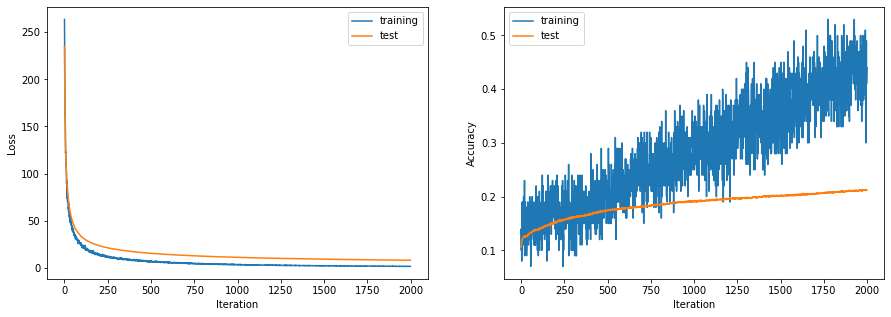

In [32]:
X_tr, X_ts, y_tr, y_ts = make_train_test_data(train_dataset, test_dataset, n=500)
print(X_tr.shape, X_ts.shape)
history6 = train_model(X_tr, X_ts, y_tr, y_ts, ITR=2000)
plot_history(history6) 

`Training Data = 1000` 

1000
torch.Size([1000, 28, 28]) torch.Size([10000, 28, 28])
Iteration 0: Loss = 211.8099, Accuracy = 0.1300 Test Loss = 204.2894, Test Accuracy = 0.1085
Iteration 1: Loss = 173.6725, Accuracy = 0.1000 Test Loss = 164.9772, Test Accuracy = 0.1139
Iteration 2: Loss = 142.2278, Accuracy = 0.1600 Test Loss = 139.7649, Test Accuracy = 0.1146
Iteration 3: Loss = 127.1781, Accuracy = 0.1100 Test Loss = 122.8500, Test Accuracy = 0.1196
Iteration 4: Loss = 112.7187, Accuracy = 0.1200 Test Loss = 109.9587, Test Accuracy = 0.1206
Iteration 5: Loss = 104.5184, Accuracy = 0.1100 Test Loss = 100.2168, Test Accuracy = 0.1251
Iteration 6: Loss = 89.9840, Accuracy = 0.1200 Test Loss = 92.7577, Test Accuracy = 0.1260
Iteration 7: Loss = 84.9498, Accuracy = 0.1100 Test Loss = 86.3153, Test Accuracy = 0.1265
Iteration 8: Loss = 86.9755, Accuracy = 0.1700 Test Loss = 81.2492, Test Accuracy = 0.1264
Iteration 9: Loss = 75.5122, Accuracy = 0.1300 Test Loss = 76.6333, Test Accuracy = 0.1273
Iteration 10: Loss

/var/folders/bg/yqgwsftd079fpjycqm6w_4_40000gp/T/ipykernel_2670/1392350790.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_dataset.data, dtype=torch.float32) / 255
/var/folders/bg/yqgwsftd079fpjycqm6w_4_40000gp/T/ipykernel_2670/1392350790.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_dataset.data, dtype=torch.float32) / 255


Iteration 18: Loss = 50.1843, Accuracy = 0.1000 Test Loss = 52.9601, Test Accuracy = 0.1313
Iteration 19: Loss = 49.5442, Accuracy = 0.0900 Test Loss = 51.4115, Test Accuracy = 0.1303
Iteration 20: Loss = 47.3929, Accuracy = 0.1500 Test Loss = 49.9079, Test Accuracy = 0.1294
Iteration 21: Loss = 45.5690, Accuracy = 0.1100 Test Loss = 48.6352, Test Accuracy = 0.1317
Iteration 22: Loss = 44.8870, Accuracy = 0.1600 Test Loss = 47.3045, Test Accuracy = 0.1316
Iteration 23: Loss = 41.4384, Accuracy = 0.1200 Test Loss = 46.1868, Test Accuracy = 0.1323
Iteration 24: Loss = 44.6404, Accuracy = 0.1100 Test Loss = 44.9626, Test Accuracy = 0.1317
Iteration 25: Loss = 40.4354, Accuracy = 0.1800 Test Loss = 44.0280, Test Accuracy = 0.1310
Iteration 26: Loss = 38.2566, Accuracy = 0.1600 Test Loss = 43.0590, Test Accuracy = 0.1316
Iteration 27: Loss = 40.9470, Accuracy = 0.1400 Test Loss = 42.0694, Test Accuracy = 0.1322
Iteration 28: Loss = 38.6458, Accuracy = 0.2100 Test Loss = 41.3177, Test Accura

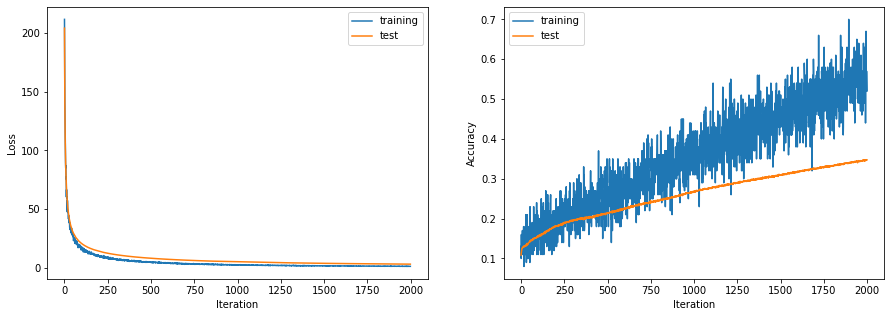

In [31]:
X_tr, X_ts, y_tr, y_ts = make_train_test_data(train_dataset, test_dataset, n=1000)
print(X_tr.shape, X_ts.shape)
history7 = train_model(X_tr, X_ts, y_tr, y_ts, ITR=2000)
plot_history(history7)

`Training Data = 10000`

10000
torch.Size([10000, 28, 28]) torch.Size([10000, 28, 28])
Iteration 0: Loss = 78.7406, Accuracy = 0.1400 Test Loss = 75.2497, Test Accuracy = 0.1272


/var/folders/bg/yqgwsftd079fpjycqm6w_4_40000gp/T/ipykernel_2670/1392350790.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_dataset.data, dtype=torch.float32) / 255
/var/folders/bg/yqgwsftd079fpjycqm6w_4_40000gp/T/ipykernel_2670/1392350790.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_dataset.data, dtype=torch.float32) / 255


Iteration 1: Loss = 49.7004, Accuracy = 0.1400 Test Loss = 49.8086, Test Accuracy = 0.1263
Iteration 2: Loss = 41.2468, Accuracy = 0.1300 Test Loss = 38.6273, Test Accuracy = 0.1301
Iteration 3: Loss = 31.2275, Accuracy = 0.1100 Test Loss = 32.2685, Test Accuracy = 0.1335
Iteration 4: Loss = 23.4190, Accuracy = 0.1600 Test Loss = 28.1362, Test Accuracy = 0.1370
Iteration 5: Loss = 25.1672, Accuracy = 0.0800 Test Loss = 25.1044, Test Accuracy = 0.1398
Iteration 6: Loss = 21.9486, Accuracy = 0.1700 Test Loss = 22.7665, Test Accuracy = 0.1462
Iteration 7: Loss = 21.4685, Accuracy = 0.1400 Test Loss = 20.9165, Test Accuracy = 0.1501
Iteration 8: Loss = 19.4022, Accuracy = 0.1300 Test Loss = 19.4030, Test Accuracy = 0.1516
Iteration 9: Loss = 18.2619, Accuracy = 0.2000 Test Loss = 18.1541, Test Accuracy = 0.1543
Iteration 10: Loss = 17.0207, Accuracy = 0.1500 Test Loss = 17.0448, Test Accuracy = 0.1586
Iteration 11: Loss = 17.1912, Accuracy = 0.1200 Test Loss = 16.1404, Test Accuracy = 0.16

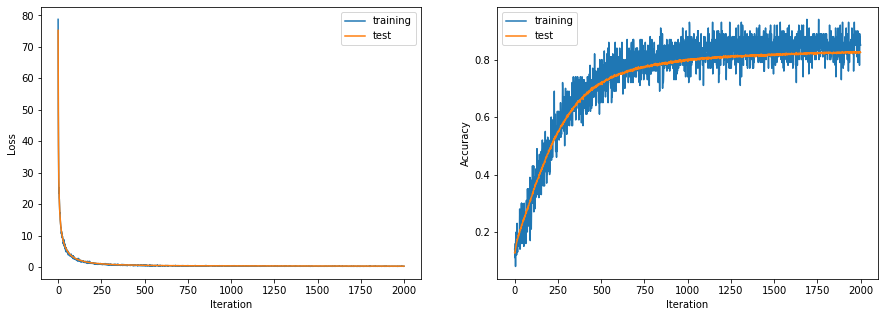

In [27]:
X_tr, X_ts, y_tr, y_ts = make_train_test_data(train_dataset, test_dataset, n=10000)
print(X_tr.shape, X_ts.shape)
history8 = train_model(X_tr, X_ts, y_tr, y_ts, ITR=2000)
plot_history(history8) 

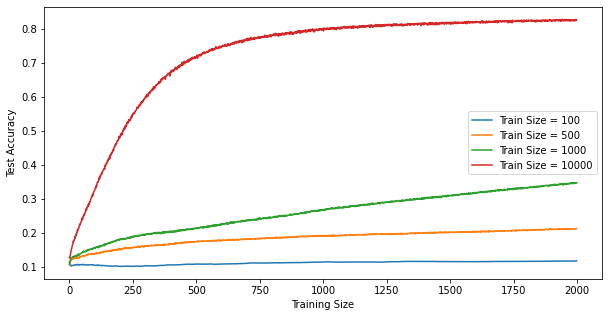

In [36]:
plt.figure(figsize=(10,5))
plt.plot(history5['test_acc'], label='Train Size = 100')
plt.plot(history6['test_acc'], label='Train Size = 500')
plt.plot(history7['test_acc'], label='Train Size = 1000')
plt.plot(history8['test_acc'], label='Train Size = 10000')
plt.legend()
plt.xlabel('Training Size')
plt.ylabel('Test Accuracy')
plt.show() 

`Comment on the accuracy as a function of dataset size:`

This plot shows the test accuracy for different train size. It is clearly visible that when we have a larger training set, test accuracy improves significantly. 

When N=10000 which is equal to the test set size, the performance is better. And, when the train size is significantly lower than the test size, performance on test set is very low. 

### 6. Bonus

In [75]:
# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

In [80]:
learning_rate = 0.01
ITR = 100

In [81]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(784, 10)   
        self.linear.weight.data.fill_(0)    # set initial weights to zero
        self.linear.bias.data.fill_(0)      # set initial biases to zero

    
    def forward(self, x):
        x = x.view(-1, 784)   
        out = self.linear(x)
        return out

model = LinearClassifier()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_mse = nn.MSELoss() 

train_losses = [] 
test_losses = [] 
train_acc = []
test_acc = [] 

for epoch in range(ITR):
    tr_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_mse(outputs, torch.nn.functional.one_hot(labels, num_classes=10).float())
        pred_tr = torch.argmax(outputs, dim=1)
        tr_correct += torch.sum(pred_tr == labels).item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(loss) 
    tr_accuracy = tr_correct / len(train_dataset)
    train_acc.append(tr_accuracy) 

    total_correct = 0
    for x, y in test_loader:
        x = x.view(-1, 784) 
        y_pred = model(x)
        loss_ts = loss_mse(y_pred, torch.nn.functional.one_hot(y, num_classes=10).float())
        pred = torch.argmax(y_pred, dim=1)
        total_correct += torch.sum(pred == y).item()
    test_accuracy = total_correct / len(test_dataset) 
    
    test_losses.append(loss_ts) 
    test_acc.append(test_accuracy) 

    print(f"Iteration:{epoch} Train Loss: {loss.item():0.4f}, Train Accuracy: {tr_accuracy:0.4f} Test Loss: {loss_ts:0.4f},  Test accuracy: {test_accuracy:0.4f}")

history_ = dict() 
history_['acc']       = train_acc 
history_['loss']      = train_losses
history_['test_acc']  = test_acc
history_['test_loss'] = test_losses 



Iteration:0 Train Loss: 0.0507, Train Accuracy: 0.7838 Test Loss: 0.0520,  Test accuracy: 0.8244
Iteration:1 Train Loss: 0.0470, Train Accuracy: 0.8285 Test Loss: 0.0493,  Test accuracy: 0.8439
Iteration:2 Train Loss: 0.0420, Train Accuracy: 0.8399 Test Loss: 0.0481,  Test accuracy: 0.8487
Iteration:3 Train Loss: 0.0440, Train Accuracy: 0.8443 Test Loss: 0.0474,  Test accuracy: 0.8547
Iteration:4 Train Loss: 0.0451, Train Accuracy: 0.8471 Test Loss: 0.0469,  Test accuracy: 0.8552
Iteration:5 Train Loss: 0.0431, Train Accuracy: 0.8492 Test Loss: 0.0464,  Test accuracy: 0.8569
Iteration:6 Train Loss: 0.0404, Train Accuracy: 0.8504 Test Loss: 0.0460,  Test accuracy: 0.8581
Iteration:7 Train Loss: 0.0400, Train Accuracy: 0.8511 Test Loss: 0.0459,  Test accuracy: 0.8588
Iteration:8 Train Loss: 0.0399, Train Accuracy: 0.8523 Test Loss: 0.0456,  Test accuracy: 0.8602
Iteration:9 Train Loss: 0.0388, Train Accuracy: 0.8527 Test Loss: 0.0454,  Test accuracy: 0.8613
Iteration:10 Train Loss: 0.046

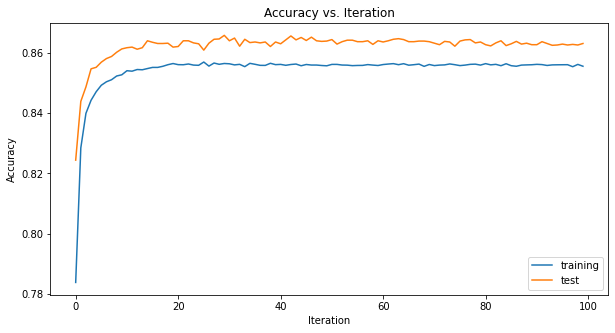

In [113]:


plt.figure(figsize=(10,5))
plt.plot(history_['acc'], label='training')
plt.plot(history_['test_acc'], label='test') 
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration')
plt.legend()
plt.show()



In [121]:
best_score_idx2 = torch.argmax(torch.Tensor(history_['test_acc'])).item()
print( "Using Linear Classifier, Best Test Accuracy: ", history_['test_acc'][best_score_idx2] ) 
print( "My Best Test Accuracy: ", test_acc0[2] )

Using Linear Classifier, Best Test Accuracy:  0.8658
My Best Test Accuracy:  0.8578000068664551


From this comparison, we can see that my scratch implementation gives similar/close test accuracy to the PyTorch linear model. 